# Segmentation

- If we want to use segmentation showing changes over time will be better to store as a table in the DB rather than recreating on each run!

In [14]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from utils import style
from sklearn.cluster import KMeans
from pywaffle import Waffle
import jenkspy
import numpy as np
import plotly.graph_objects as go
path = '/Users/jennamiles/Documents/credentials'

In [6]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [7]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Vesterbro']
plt.rcParams['font.sans-serif'] = ['Akkurat Pro']
plt.rcParams['font.size'] = '15'

In [8]:
df = query_from_file('pure.sql')

In [9]:
df = df[['customer_id','total_amount','transaction_date','receipt_id']].drop_duplicates()

In [10]:
now = df['transaction_date'].max() + timedelta(days=1)
df['days_since_receipt'] = df['transaction_date'].apply(lambda x: (now - x).days)

In [11]:
period = 365 #will define the frequency and monetary value over this period

In [12]:
#recency and frequency  --> not sure this is the quickest way
aggr = {
    'days_since_receipt': lambda x: x.min(),  # the number of days since last order (recency)
    'transaction_date': lambda x: len([d for d in x if d >= now - timedelta(days=period)]), # the total number of orders in the last period (frequency)
}
rf = df.groupby('customer_id').agg(aggr).reset_index()
rf.rename(columns={'days_since_receipt': 'recency', 'transaction_date': 'frequency'}, inplace=True)

#monetary
monetary = (df[df['transaction_date'] >= now - timedelta(days=period)].groupby('customer_id').sum()['total_amount']/100).reset_index()
rfm = pd.merge(rf, monetary, on = 'customer_id', how = 'left').fillna(0)
rfm.columns = ['customer_id','recency','frequency','monetary']
rfm.head()

,customer_id,recency,frequency
0,00039533-dc80-4bd1-bc37-fab5ca4bd343,634,0
1,000cdac5-137c-4610-acf5-820e63c848a1,578,0
2,000ed711-2f2a-4070-97b5-554feec4a0ae,596,0
3,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,447,0
4,001c79a3-196a-4207-8479-f87159a69574,687,0


- need to change the frequency calcaultion for last month so that only goes up to the last month
- might just be easier to create a subset dataframe

In [73]:
#get the metrics for last month 
last_month = df['transaction_date'].max() - timedelta(days=30)
df['days_since_receipt'] = df['transaction_date'].apply(lambda x: (last_month - x).days)

#recency and frequency  --> not sure this is the quickest way
aggr = {
    'days_since_receipt': lambda x: x.min(),  # the number of days since last order (recency)
    'transaction_date': lambda x: len([d for d in x if d >= last_month - timedelta(days=period)]), # the total number of orders in the last period (frequency)
}
rf = df.groupby('customer_id').agg(aggr).reset_index()
rf.rename(columns={'days_since_receipt': 'recency', 'transaction_date': 'frequency '}, inplace=True)
rf = rf[rf['recency']>=0]
#monetary
monetary = (df[(df['transaction_date'] >= last_month - timedelta(days=period))&(df['transaction_date'] <= last_month)].groupby('customer_id').sum()['total_amount']/100).reset_index()
rfm_last = pd.merge(rf, monetary, on = 'customer_id', how = 'left').fillna(0)
rfm_last.columns = ['customer_id','recency','frequency','monetary']
rfm_last.head()

,customer_id,recency,frequency,monetary
0,00039533-dc80-4bd1-bc37-fab5ca4bd343,603,0,0.0
1,000cdac5-137c-4610-acf5-820e63c848a1,547,0,0.0
2,000ed711-2f2a-4070-97b5-554feec4a0ae,565,0,0.0
3,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,416,0,0.0
4,001c79a3-196a-4207-8479-f87159a69574,656,0,0.0


In [74]:
rfm[rfm['recency']<30]

,customer_id,recency,frequency,monetary,jenks_monetary,jenks_frequency,jenks_recency,RFM score jenks,segment
16,00488c14-4202-4cc1-b8f5-3c1edbb6c816,6,3,23.77,2,2,4,422,Newbies: Low value
23,005a7566-b6b6-4765-8169-b39a7d8621f2,1,3,4.05,1,2,4,421,Newbies: Low value
30,006a81db-35b8-4dbb-aa4c-f4c4a8ad9da3,17,1,2.99,1,1,4,411,Newbies: Low value
49,00b43521-e392-483f-95b3-076d2c087d16,19,11,13.25,2,3,4,432,Loyal: Bargain Hunters
63,0108ed92-bf47-4c1c-a456-8890c90cceb4,8,5,53.91,3,2,4,423,Newbies: Potential champions
...,...,...,...,...,...,...,...,...,...
13997,fe23ed4c-b623-4191-a69b-d512703af6bc,8,1,2.15,1,1,4,411,Newbies: Low value
14027,fe9080ee-2802-4690-9ace-0e6b59513216,12,5,14.82,2,2,4,422,Newbies: Low value
14072,ff503a4a-e1e6-45f8-a15d-4ab1a2ea513f,28,4,23.50,2,2,4,422,Newbies: Low value
14083,ff7ba28d-7894-45e1-ac8f-1582da5c67a8,8,8,33.41,2,2,4,422,Newbies: Low value


In [75]:
rfm_last[rfm_last.customer_id == '006a81db-35b8-4dbb-aa4c-f4c4a8ad9da3']

,customer_id,recency,frequency,monetary


# Jenks

In [15]:
m_breaks = jenkspy.jenks_breaks(rfm['monetary'], nb_class=4)
f_breaks = jenkspy.jenks_breaks(rfm['frequency'], nb_class=4)
r_breaks = jenkspy.jenks_breaks(rfm['recency'], nb_class=4)
m_breaks

[0.0, 8.55, 43.94, 143.63, 326.82]

In [76]:
def jenks_monetary(x):
    if x <= m_breaks[1]:
        return 1
    elif x <= m_breaks[2]:
        return 2
    elif x <= m_breaks[3]:
        return 3
    elif x <= m_breaks[4]:
        return 4
    else:
        return 5
def jenks_frequency(x):
    if x <= f_breaks[1]:
        return 1
    elif x <= f_breaks[2]:
        return 2
    elif x <= f_breaks[3]:
        return 3
    elif x <= f_breaks[4]:
        return 4
    else:
        return 5
def jenks_recency(x):
    if x <= r_breaks[1]:
        return 4
    elif x <= r_breaks[2]:
        return 3
    elif x <= r_breaks[3]:
        return 2
    elif x <= r_breaks[4]:
        return 1
    else:
        return 0
    
rfm['jenks_monetary'] = rfm['monetary'].apply(lambda x: jenks_monetary(x))
rfm['jenks_frequency'] = rfm['frequency'].apply(lambda x: jenks_frequency(x))
rfm['jenks_recency'] = rfm['recency'].apply(lambda x: jenks_recency(x))

rfm['RFM score jenks'] = rfm['jenks_recency'].map(str) + rfm['jenks_frequency'].map(str) + rfm['jenks_monetary'].map(str)

#do the same for results from previous month:
rfm_last['jenks_monetary'] = rfm_last['monetary'].apply(lambda x: jenks_monetary(x))
rfm_last['jenks_frequency'] = rfm_last['frequency'].apply(lambda x: jenks_frequency(x))
rfm_last['jenks_recency'] = rfm_last['recency'].apply(lambda x: jenks_recency(x))

rfm_last['RFM score jenks'] = rfm_last['jenks_recency'].map(str) + rfm_last['jenks_frequency'].map(str) + rfm_last['jenks_monetary'].map(str)

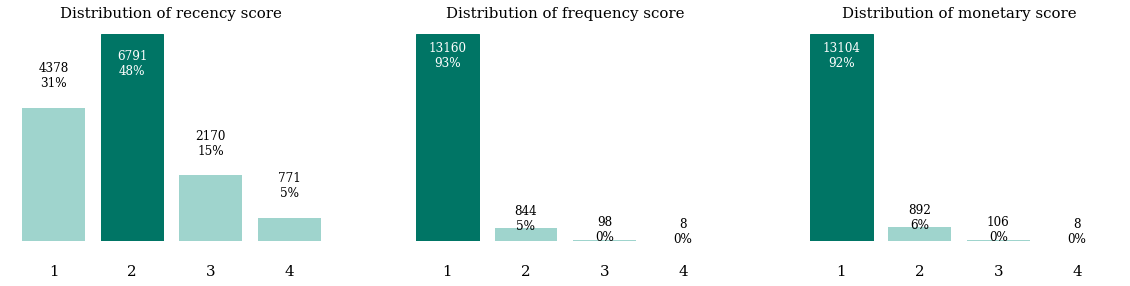

In [77]:
# plot the distribution of customers over R
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
from matplotlib.ticker import MaxNLocator

for i, p in enumerate(['jenks_recency','jenks_frequency','jenks_monetary']):
    parameters = {'jenks_recency':'recency','jenks_frequency':'frequency','jenks_monetary':'monetary'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='mint')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('Distribution of {} score'.format(parameters[p]),
                fontsize=15)
    plt.setp(ax.get_xticklabels(), fontsize=15)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('green')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value - 500,
                    '{}\n{}%'.format(int(value), int(value * 100 / y.sum())),
                   ha='center',
                   va='top',
                   color='w',
                   size = 12)
        else :
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value + 1500,
                    '{}\n{}%'.format(int(value), int(value * 100 / y.sum())),
                   ha='center',
                   va='top',
                   color='black',
                   size = 12)
            


In [78]:
#map rfm score to segment names

segt_map = {
    
    #champions = top customers all round
    r'4[3-4][3-4]': 'Loyal: Champions',
    r'4[3-4][1-2]': 'Loyal: Bargain Hunters',
    r'4[1-2][1-2]': 'Newbies: Low value',
    r'4[1-2][3-4]': 'Newbies: Potential champions',
    
    #hibernators had their last transaction a long time ago 

    r'1[1-2][1-2]': 'Hibernating: Low value',
    r'1[1-2][3-4]': 'Hibernating: Whales',
    r'1[3-4][3-4]': 'Hibernating: Champions',    
    r'1[3-4][1-2]': 'Hibernating: Bargain Hunters',
    
    r'2[1-2][1-2]': 'Inactive: Low value',
    r'2[1-2][3-4]': 'Inactive: Whales',
    r'2[3-4][3-4]': 'Inactive: Champions',
    r'2[3-4][3-4]': 'Inactive: Bargain Hunters',
    
    r'3[1-2][1-2]': 'Active: Low Value',    
    r'3[1-2][3-4]': 'Active: Whales',
    r'3[3-4][3-4]': 'Active: Champions',
    r'3[3-4][1-2]': 'Active: Bargain Hunters',


}
rfm['segment'] = rfm['RFM score jenks'].replace(segt_map, regex=True)
rfm_last['segment'] = rfm_last['RFM score jenks'].replace(segt_map, regex=True)
rfm_plot_input = rfm.groupby('segment').nunique()['customer_id']
rfm_plot_input.index.values
pcents = rfm_plot_input.values/sum(rfm_plot_input.values)

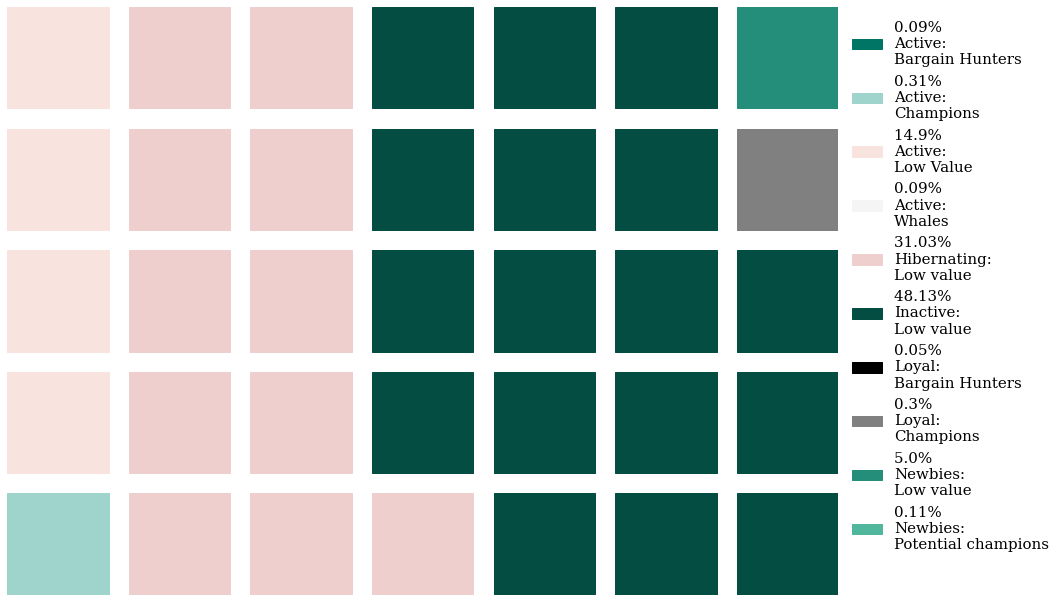

In [27]:
#sort out the labels to appear how we want 
wrapped_labels = [ label.replace(': ', ':\n') for label in rfm_plot_input.index.values ]
pcent_labels = []
for a in np.arange(len(wrapped_labels)):
    add = str(round(pcents[a]*100,2)) + '% \n' + wrapped_labels[a]
    pcent_labels.append(add)
    

fig = plt.figure(figsize=(15,12),
    FigureClass=Waffle,
    rows=5,
    columns=7,
    values=pd.Series(rfm_plot_input.values,index=pcent_labels).to_dict(),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1),'fontsize':15},
    colors=("green","mint", "pink","snow","chansey","tmnt","black","grey","merman", "sage")
)
plt.show()

### Recency change from previous month to this month
- Sankey will allow us to see where a customer group has moved from and to rather than just absolute volume changes

In [272]:
#merge jenks recency for the dataframes
rfm_recency = rfm[['customer_id','jenks_recency']]
rfm_recency_last = rfm_last[['customer_id','jenks_recency']]

#change merge to outer to allow for nulls in both
#then want to fill with 0 or something so we can identify new customers coming in 
recency_change = pd.merge(rfm_recency,rfm_recency_last, on = 'customer_id',how = 'left')
recency_change.fillna(0, inplace = True)

recency_change_vols = recency_change.groupby(['jenks_recency_y','jenks_recency_x']).nunique().reset_index()

recency_change_vols.columns = ['last month','this month','value']
recency_change_vols

,last month,this month,value
0,0.0,4,697
1,1.0,1,3547
2,2.0,1,831
3,2.0,2,6791
4,3.0,3,2170
5,4.0,4,74


In [267]:
new_source =  pd.DataFrame(data = recency_change_vols['last month'].drop_duplicates().index.values).reset_index()
new_source.columns = ['last month','new last month']
new_target=  pd.DataFrame(data = recency_change_vols['this month'].drop_duplicates()).reset_index()
new_target['new this month'] = new_target['index']+recency_change_vols['this month'].index.max()+1
recency_change_vols = pd.merge(recency_change_vols,new_source,on='last month',how ='left')
recency_change_vols = pd.merge(recency_change_vols,new_target[['this month','new this month']],on='this month',how ='left')

In [269]:
colour_map = {
    0.0: "white",
    1.0: "#9FD4CD",
    2.0 :"#EECFCE",
    3.0: "#121212",
    4.0: "#248E7A",
}
rcolours = list(recency_change_vols['last month'].append(recency_change_vols['this month']).replace(colour_map))

In [270]:
label_map = {
    0.0: "Acquired",
    1.0: "Hibernating",
    2.0 :"Inactive",
    3.0: "Active",
    4.0: "Recent",
}
rlabels = list(recency_change_vols['last month'].append(recency_change_vols['this month']).replace(label_map))

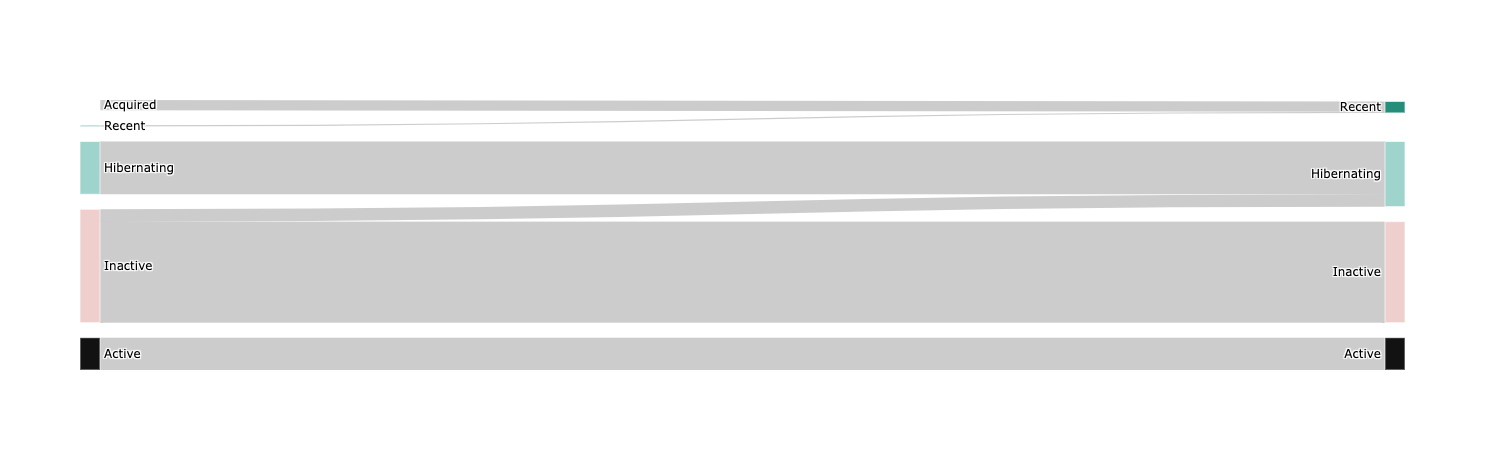

In [271]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "white", width = 0.5),
      label = rlabels, 
      color = rcolours
    ),
    link = dict(
      source = list(recency_change_vols['new last month']), #these are the first index locations rather than the source number --> this is because it need st to use the iundex to find the right value
      target = list(recency_change_vols['new this month']), #these are the min index locations too but of what should appear on the right hand side
      value =  recency_change_vols['value']
  ))])
fig.show()

- Try sankey for all segments

In [323]:
#merge jenks recency for the dataframes
rfm_segment = rfm[['customer_id','segment']]
rfm_segment_last = rfm_last[['customer_id','segment']]

#change merge to outer to allow for nulls in both
#then want to fill with 0 or something so we can identify new customers coming in 
segment_change = pd.merge(rfm_segment,rfm_segment_last, on = 'customer_id',how = 'left')
segment_change.fillna('Acquired', inplace = True)

segment_change_vols = segment_change.groupby(['segment_y','segment_x']).nunique().reset_index()
segment_change_vols.columns = ['last month','this month','value']
segment_change_vols

,last month,this month,value
0,Acquired,Loyal: Bargain Hunters,6
1,Acquired,Loyal: Champions,41
2,Acquired,Newbies: Low value,635
3,Acquired,Newbies: Potential champions,15
4,Active: Bargain Hunters,Active: Bargain Hunters,12
5,Active: Champions,Active: Champions,44
6,Active: Low Value,Active: Low Value,2102
7,Active: Whales,Active: Whales,12
8,Hibernating: Low value,Hibernating: Low value,3547
9,Inactive: Low value,Hibernating: Low value,831


In [324]:
new_source =  pd.DataFrame(data = segment_change_vols['last month'].drop_duplicates().index.values)
new_source['last month']= segment_change_vols['last month'].unique()
new_source.columns = ['new last month','last month']
segment_change_vols = pd.merge(segment_change_vols,new_source,on='last month',how ='left')
new_target = pd.DataFrame(data = segment_change_vols['this month'].drop_duplicates().index.values)+segment_change_vols['this month'].index.max()+1
new_target['this month']= segment_change_vols['this month'].unique()
new_target.columns = ['new this month','this month']
segment_change_vols = pd.merge(segment_change_vols,new_target[['this month','new this month']],on='this month',how ='left')
segment_change_vols

In [360]:
segment_change_vols

,last month,this month,value,new last month,new this month
0,Acquired,Loyal: Bargain Hunters,6,0,14
1,Acquired,Loyal: Champions,41,0,15
2,Acquired,Newbies: Low value,635,0,16
3,Acquired,Newbies: Potential champions,15,0,17
4,Active: Bargain Hunters,Active: Bargain Hunters,12,4,18
5,Active: Champions,Active: Champions,44,5,19
6,Active: Low Value,Active: Low Value,2102,6,20
7,Active: Whales,Active: Whales,12,7,21
8,Hibernating: Low value,Hibernating: Low value,3547,8,22
9,Inactive: Low value,Hibernating: Low value,831,9,22


In [351]:
colour_map = {
    "Acquired": "pink",
    "Active: Bargain Hunters": "#9FD4CD",
    "Active: Champions" :"#EECFCE",
    "Active: Low Value": "#121212",
    "Active: Whales": "#248E7A",
    "Hibernating: Low value": "white",
    "Inactive: Low value": "#9FD4CD",
    "Loyal: Bargain Hunters" :"#EECFCE",
    "Loyal: Champions": "#121212",
    "Newbies: Low value": "#248E7A", 
    "Newbies: Potential champions": "black",    
}
rcolours = list(segment_change_vols['last month'].append(segment_change_vols['this month']).replace(colour_map))
rlabels = list(segment_change_vols['last month'].append(segment_change_vols['this month']))

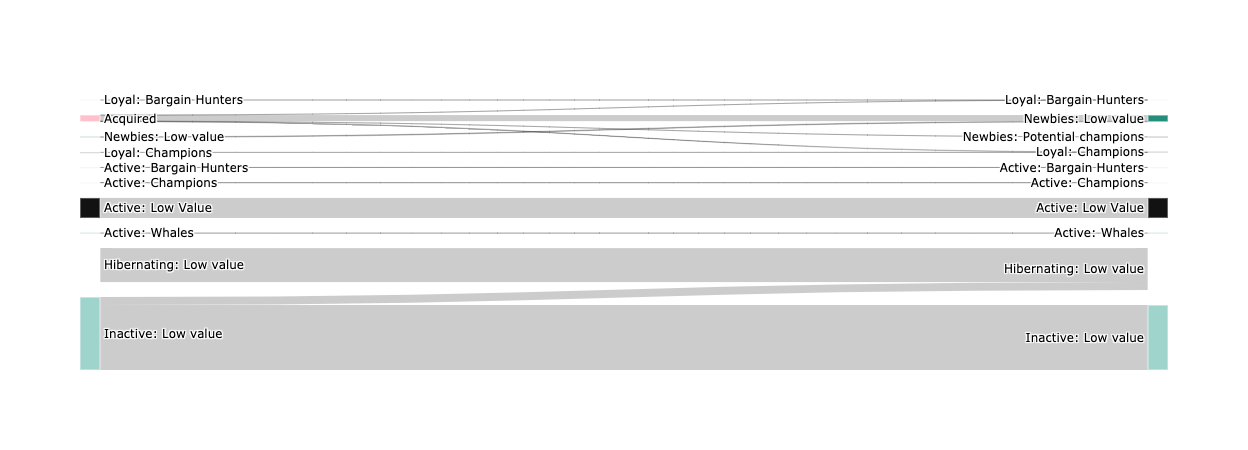

In [355]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "white", width = 0.5),
      label = rlabels, 
      color = rcolours
    ),
    link = dict(
      source = list(segment_change_vols['new last month']), #these are the first index locations rather than the source number --> this is because it need st to use the iundex to find the right value
      target = list(segment_change_vols['new this month']), #these are the min index locations too but of what should appear on the right hand side
      value =  segment_change_vols['value']
  ))])
fig.show()

In [367]:
#what if we only display the things that have changed?
segment_change_vols_subset = segment_change_vols[segment_change_vols['last month']!=segment_change_vols['this month']]
segment_change_vols_subset

,last month,this month,value,new last month,new this month
0,Acquired,Loyal: Bargain Hunters,6,0,14
1,Acquired,Loyal: Champions,41,0,15
2,Acquired,Newbies: Low value,635,0,16
3,Acquired,Newbies: Potential champions,15,0,17
9,Inactive: Low value,Hibernating: Low value,831,9,22


In [369]:

segment_change_vols_subset = segment_change_vols_subset.drop(['new last month','new this month'],axis = 1).reset_index()
new_source =  pd.DataFrame(data = segment_change_vols_subset['last month'].drop_duplicates().index.values)
new_source['last month']= segment_change_vols_subset['last month'].unique()
new_source.columns = ['new last month','last month']
segment_change_vols_subset = pd.merge(segment_change_vols_subset,new_source,on='last month',how ='left')


new_target = pd.DataFrame(data = segment_change_vols_subset['this month'].drop_duplicates().index.values)+segment_change_vols_subset['this month'].index.max()+1
new_target['this month']= segment_change_vols_subset['this month'].unique()
new_target.columns = ['new this month','this month']
segment_change_vols_subset = pd.merge(segment_change_vols_subset,new_target[['this month','new this month']],on='this month',how ='left')
segment_change_vols_subset


,index,last month,this month,value,new last month,new this month
0,0,Acquired,Loyal: Bargain Hunters,6,0,5
1,1,Acquired,Loyal: Champions,41,0,6
2,2,Acquired,Newbies: Low value,635,0,7
3,3,Acquired,Newbies: Potential champions,15,0,8
4,4,Inactive: Low value,Hibernating: Low value,831,4,9


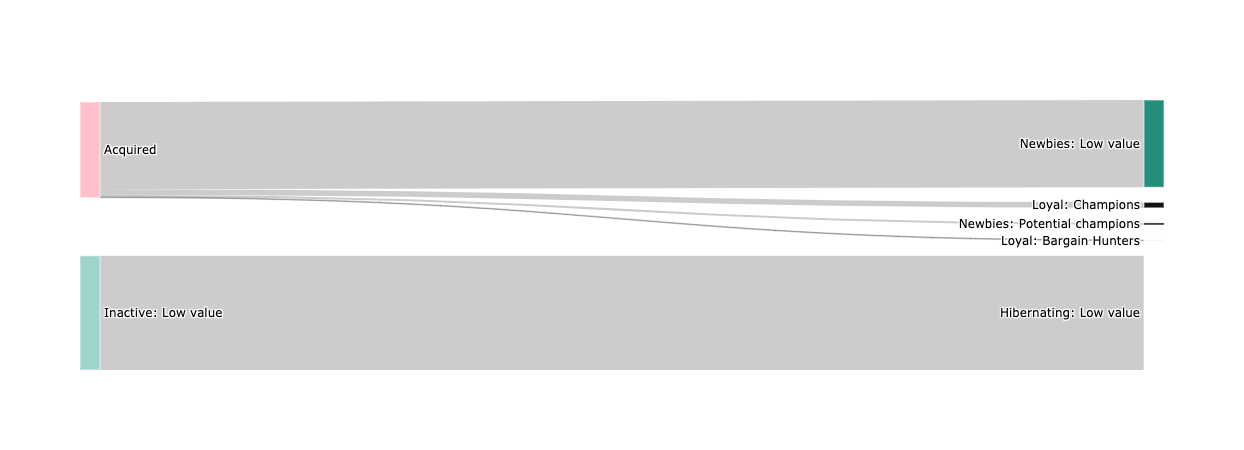

In [370]:

rcolours = list(segment_change_vols_subset['last month'].append(segment_change_vols_subset['this month']).replace(colour_map))
rlabels = list(segment_change_vols_subset['last month'].append(segment_change_vols_subset['this month']))

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "white", width = 0.5),
      label = rlabels, 
      color = rcolours
    ),
    link = dict(
      source = list(segment_change_vols_subset['new last month']), #these are the first index locations rather than the source number --> this is because it need st to use the iundex to find the right value
      target = list(segment_change_vols_subset['new this month']), #these are the min index locations too but of what should appear on the right hand side
      value =  segment_change_vols_subset['value']
  ))])
fig.show()


### Change in segment counts - Long term

In [394]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
cal_end = datetime.now().replace(day=1).date()
calendar = sorted([cal_end + relativedelta(months=-c) for c in np.arange(7)])
print(calendar)

[datetime.date(2020, 10, 1), datetime.date(2020, 11, 1), datetime.date(2020, 12, 1), datetime.date(2021, 1, 1), datetime.date(2021, 2, 1), datetime.date(2021, 3, 1), datetime.date(2021, 4, 1)]


# To Do:
- Add recency to loop
- Work out why the volumes look odd and numbers go up to 5?
- Visualise


In [426]:
#loop through month starts going back 6 months 
#assign the RFM segments 
frequency = pd.DataFrame()
monetary = pd.DataFrame()
for date2 in calendar:
    date1 = date2 + relativedelta(months = -12)
    df_period = df[(df['transaction_date'].dt.date >=date1) & (df['transaction_date'].dt.date<date2)]
    #frequency
    f = df_period.groupby('customer_id').nunique()['receipt_id'].apply(lambda x: jenks_frequency(x)).reset_index()
    f_counts = f.groupby('receipt_id').nunique()['customer_id']
    frequency=frequency.append(f_counts.T)
    #monetary
    m = df_period.groupby('customer_id').sum()['total_amount'].apply(lambda x: jenks_monetary(x)).reset_index()
    m_counts = m.groupby('total_amount').nunique()['customer_id']
    monetary=monetary.append(m_counts.T)    
    #recency 
    r = df_period.groupby('customer_id').max()['transaction_date'].dt
    apply(lambda x: jenks_monetary(x)).reset_index()
    m_counts = m.groupby('total_amount').nunique()['customer_id']
    monetary=monetary.append(m_counts.T) 

frequency.fillna(0,inplace = True)
frequency.index = calendar

monetary.fillna(0,inplace = True)
monetary.index = calendar

,2,3,4,5
2020-10-01,1.0,170.0,1164.0,7541.0
2020-11-01,1.0,163.0,1087.0,7070.0
2020-12-01,1.0,142.0,1000.0,6181.0
2021-01-01,1.0,127.0,914.0,5462.0
2021-02-01,1.0,110.0,798.0,4344.0
2021-03-01,1.0,95.0,621.0,2999.0
2021-04-01,1.0,81.0,441.0,2005.0
